In [2]:
#Treadmill_task_data_analysis
import warnings
warnings.filterwarnings("ignore")

In [3]:
#analysis global parameters
import pandas as pd

RzFloor = 150
RzCeiling = 170
lick_position_threshold = 30
binning_window = 1 #cm or min 

lick_data_in_each_condiction = pd.DataFrame(columns=
                                            ['condiction_name','mean_of_dalta_COM_mean', 'sem_of_dalta_COM_mean', 'mean_of_dalta_COM_CV_within_trial', 'sem_of_dalta_COM_CV_within_trial','mean_of_dalta_COM_CV_across_trial', 'sem_of_dalta_COM_CV_across_trial',])

Raw Data column annotation
0 : Timestamp
1 : Trial number
2 : Distance
3 : Speed
4 : Accumulate lick number in current trial
5 : Accumulate reward in this session
6 : Slap2 sync signal 
7 : Reward zone floor
8 : Reward zone ceil
9 : Trial end distance
10 : Is operant conditioning
11 : Random reward smooth_window
12 : Random reward probability
13 : Is random reward
14 : Auditory cue frequency
15 : Is cue swap

In [20]:
#read datas
import os
import pandas as pd
from tkinter import Tk, filedialog

#select file
def select_files_and_get_paths():
    root = Tk()
    root.attributes('-topmost', True)  # 將主視窗設置為最上層
    root.withdraw()

    file_paths = []

    while True:

        files = filedialog.askopenfilenames(parent=root, title='選擇資料檔案', filetypes=[('CSV files', '*.csv')])
        
        if not files:
            break
        file_paths.extend(files)

    return file_paths

data_file_paths = select_files_and_get_paths()
file_names = [os.path.basename(path) for path in data_file_paths]

all_raw_df = {}

for index, data_file_dir in enumerate(data_file_paths):
    data_file_name = os.path.basename(data_file_dir)
    file_name_parts = data_file_name.split('_')
    mouseID = file_name_parts[0]
    Date = file_name_parts[1]
    schedule = file_name_parts[2]
    
    print('Processing file: ', data_file_dir)

    df = pd.read_csv(data_file_dir, true_values=['TRUE'], false_values=['FALSE'], low_memory=False, header=None, skiprows=1)

    all_raw_df[index] = df


Processing file:  G:/works/Data_archive/Treadmill_task/Grouped_Data/im(Proximal limb muscles)180/ctl_saline/1PL001D_0318_30saline_150-170cm_12ul.csv
Processing file:  G:/works/Data_archive/Treadmill_task/Grouped_Data/im(Proximal limb muscles)180/ctl_saline/1PL001I_0327_30saline_150-170cm_12ul.csv
Processing file:  G:/works/Data_archive/Treadmill_task/Grouped_Data/im(Proximal limb muscles)180/ctl_saline/1PL001J_0327_30saline_150-170cm_12ul.csv
Processing file:  G:/works/Data_archive/Treadmill_task/Grouped_Data/im(Proximal limb muscles)180/ctl_saline/1PL001K_0327_30saline_150-170cm_12ul.csv
Processing file:  G:/works/Data_archive/Treadmill_task/Grouped_Data/im(Proximal limb muscles)180/ctl_saline/3PL006E_1114_30saline_150-170cm_7ul.csv
Processing file:  G:/works/Data_archive/Treadmill_task/Grouped_Data/im(Proximal limb muscles)180/ctl_saline/3PL006G_1027_37saline_150-170cm_7ul.csv
Processing file:  G:/works/Data_archive/Treadmill_task/Grouped_Data/im(Proximal limb muscles)180/ctl_saline/

In [32]:
#read datas and group by mouseID
import os
import pandas as pd
from tkinter import Tk, filedialog

#select file
def select_files_and_get_paths():
    root = Tk()
    root.attributes('-topmost', True)  # 將主視窗設置為最上層
    root.withdraw()

    file_paths = []

    while True:
        files = filedialog.askopenfilenames(parent=root, title='選擇資料檔案', filetypes=[('CSV files', '*.csv')])
        if not files:
            break
        file_paths.extend(files)

    return file_paths

data_file_paths = select_files_and_get_paths()
file_names = [os.path.basename(path) for path in data_file_paths]

all_raw_df = {}

for data_file_dir in data_file_paths:
    data_file_name = os.path.basename(data_file_dir)
    file_name_parts = data_file_name.split('_')
    mouseID = file_name_parts[0]
    Date = file_name_parts[1]
    schedule = file_name_parts[2]
    
    df = pd.read_csv(data_file_dir, true_values=['TRUE'], false_values=['FALSE'], low_memory=False, header=None, skiprows=1)

    if mouseID not in all_raw_df:
        all_raw_df[mouseID] = []
    
    all_raw_df[mouseID].append(df)

In [4]:
#functions of extracting information from raw data
import numpy as np

def get_lick_pattern_in_a_session(df, RzFloor, RzCeiling):
    # 將 df 依 trial number 分組
    grouped = df.groupby(df.columns[1])

    # 取出所有每當 lick 增加時，距離的數值
    df['prev_lick_number'] = df[df.columns[4]].shift(1)
    df['lick_happened'] = df[df.columns[4]] > df['prev_lick_number']
    df['lick_happened'] = df['lick_happened'].fillna(False)
    df['position_of_lick'] = df[df['lick_happened']][df.columns[2]]

    # 只要 reward zone 前所有 lick 與 reward zone 中的第一個 lick，去除其他的
    df['position_of_lick'] = df['position_of_lick'][df['position_of_lick'] < RzFloor]
    df['position_of_lick'] = df['position_of_lick'][df['position_of_lick'] > lick_position_threshold]
    first_lick_in_reward_zone = grouped.apply(lambda g: g[(g[df.columns[2]] >= RzFloor) & (g[df.columns[2]] <= RzCeiling)].iloc[0] 
                                            if not g[(g[df.columns[2]] >= RzFloor) & (g[df.columns[2]] <= RzCeiling)].empty else None)

    # 將 first_lick_in_reward_zone 的值加入到 df['position_of_lick'] 中對應的位置
    df.loc[first_lick_in_reward_zone.index, 'position_of_lick'] = first_lick_in_reward_zone

    return df #返回包含一欄'position_of_lick'的df，該欄在每次lick發生時，其值會是當下的位置。未發生lick時，其值為false
    
def calculate_avg_max_speed_in_a_session(df):
    # 將 df 依trial number分組
    grouped = df.groupby(df.columns[1])

    # 找到每一Trial中速度的最大值
    max_values = grouped[df.columns[3]].max()

    #去除異常值
    max_values = max_values[max_values < 100]

    # 將每一Trial中速度的最大值相加後平均
    avg_max = max_values.mean()

    # 返回這個平均值
    return avg_max
    
def calculate_avg_lick_deviation_in_a_session(df, RzFloor, RzCeiling):
    
    df_with_lick_pattern = get_lick_pattern_in_a_session(df, RzFloor, RzCeiling)
    
    # 將 df 依 trial number 分組
    grouped = df_with_lick_pattern.groupby(df.columns[1])

    # 計算每一組中，數值的平均
    trial_avg_of_lick_position = grouped['position_of_lick'].mean()

    # 計算所有組別的數值的平均
    session_avg_of_lick_position = trial_avg_of_lick_position.mean()

    # 計算deviation
    session_avg_deviation_of_lick_position = RzFloor - session_avg_of_lick_position

    # 返回這一個平均
    return session_avg_deviation_of_lick_position

def Trial_success_and_fail(df, RzFloor, RzCeiling):
    trial_df = df.groupby(df[1])
    success_trial_df = pd.DataFrame([])
    fail_trial_df = pd.DataFrame([])

    for trial_number, group_data in trial_df:

        #找RZ裡的licking
        data_with_licking = group_data[group_data[4].diff() != 0] 
        data_with_licking_RzFloor = data_with_licking[data_with_licking[2] >= RzFloor]
        data_with_licking_RzFloor_RZceil = data_with_licking_RzFloor[data_with_licking_RzFloor[2] <= RzCeiling]

        #如果RZ裡有licking
        if (len(data_with_licking_RzFloor_RZceil) > 0):
            success_trial_df = pd.concat([success_trial_df, group_data], axis=0, ignore_index=True)
        else:
            fail_trial_df = pd.concat([fail_trial_df, group_data], axis=0, ignore_index=True)

    return success_trial_df, fail_trial_df

def injection_at_which_trial(data_file_paths):
    data_file_name = os.path.basename(data_file_paths)
    file_name_parts = data_file_name.split('_')
    mouseID = file_name_parts[0]
    Date = file_name_parts[1]
    schedule = file_name_parts[2]
    if "CTZ" in schedule or "saline" in schedule or "baseline" in schedule:
        injection = True
        injection_trial = schedule[:2]
        
    else:
        injection = False
        injection_trial = np.nan
        
    return injection, injection_trial
    

IndexError: list index out of range

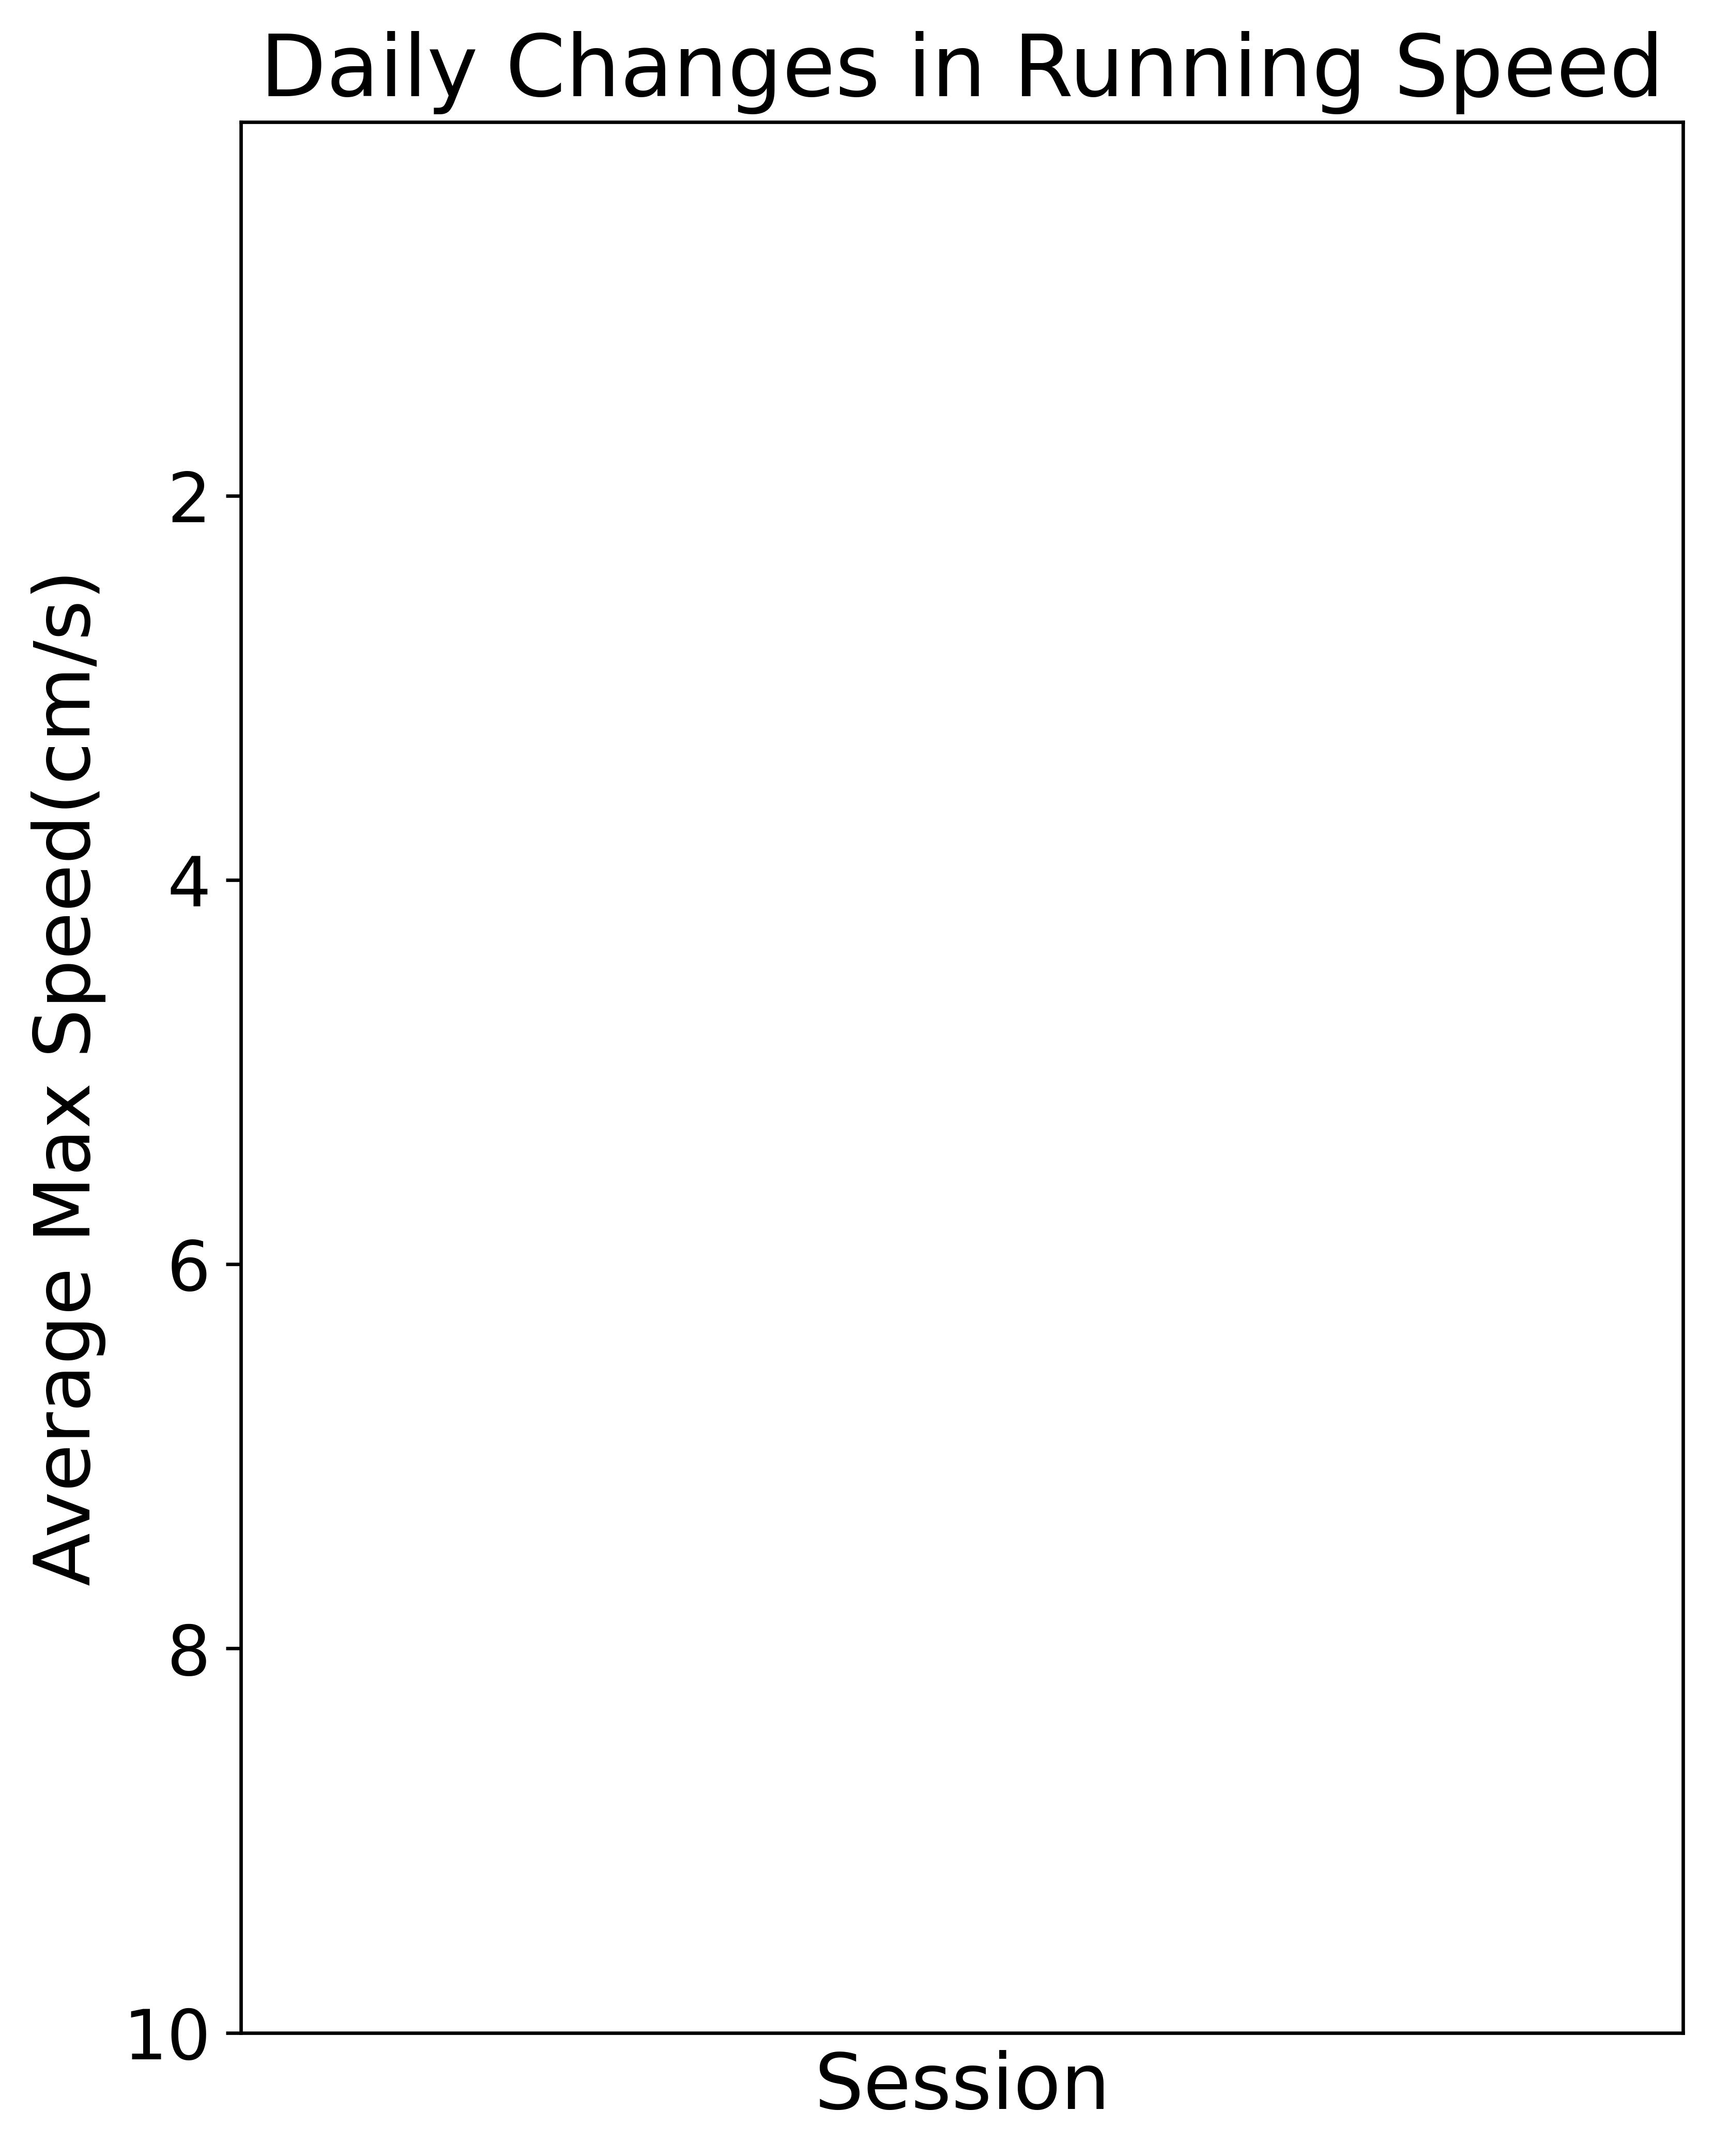

In [18]:
#evaluate_single_animal_training_performance
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#plot daily changes in running speed
avg_max_speeds = [calculate_avg_max_speed_in_a_session(df) for df in all_raw_df.values()]

# 創建一個新的 DataFrame 來儲存結果
df = pd.DataFrame({
    'Session': range(1, len(avg_max_speeds) + 1),
    'Average Max Speed(cm/s)': avg_max_speeds
})

# 使用 seaborn 繪製結果
plt.figure(figsize=(6, 8), dpi=600)
sns.lineplot(x='Session', y='Average Max Speed(cm/s)', data=df, marker='o')


# 設定座標軸的刻度
plt.xlim(left=1, right=len(avg_max_speeds))
plt.xticks(np.arange(1, len(avg_max_speeds) + 1, step=1),size=16)
plt.yticks(size=16)
plt.xlabel('Session',size=18)
plt.ylabel('Average Max Speed(cm/s)',size=18)
plt.ylim(bottom=10)

# 設定圖表的標題
plt.title('Daily Changes in Running Speed', size=20)

# 顯示圖表
#plt.show()
#save the plot in the same directory
save_dir = os.path.dirname(data_file_paths[0])
plt.savefig(os.path.join(save_dir, 'Daily Changes in Running Speed.png'))

#plot daily changes in lick deviation
avg_lick_deviation = [calculate_avg_lick_deviation_in_a_session(df, RzFloor, RzCeiling) for df in all_raw_df.values()]

# 創建一個新的 DataFrame 來儲存結果
df = pd.DataFrame({
    'Session': range(1, len(avg_lick_deviation) + 1),
    'Average Lick Deviation(cm)': avg_lick_deviation
})

# 使用 seaborn 繪製結果
plt.figure(figsize=(6, 8), dpi=600)
sns.lineplot(x='Session', y='Average Lick Deviation(cm)', data=df, marker='o')

# 設定座標軸的刻度
plt.xlim(left=1, right=len(avg_max_speeds))
plt.xticks(np.arange(1, len(avg_max_speeds) + 1, step=1),size=16)
plt.yticks(size=16)
plt.xlabel('Session',size=18)
plt.ylabel('Average Lick Deviation(cm)',size=18)
plt.ylim(bottom=10)

# 設定圖表的標題
plt.title('Daily Changes in Lick Deviation', size=20)

# 顯示圖表
#plt.show()

#save the plot in the same directory
save_dir = os.path.dirname(data_file_paths[0])
plt.savefig(os.path.join(save_dir, 'Daily Changes in Lick Deviation.png'))



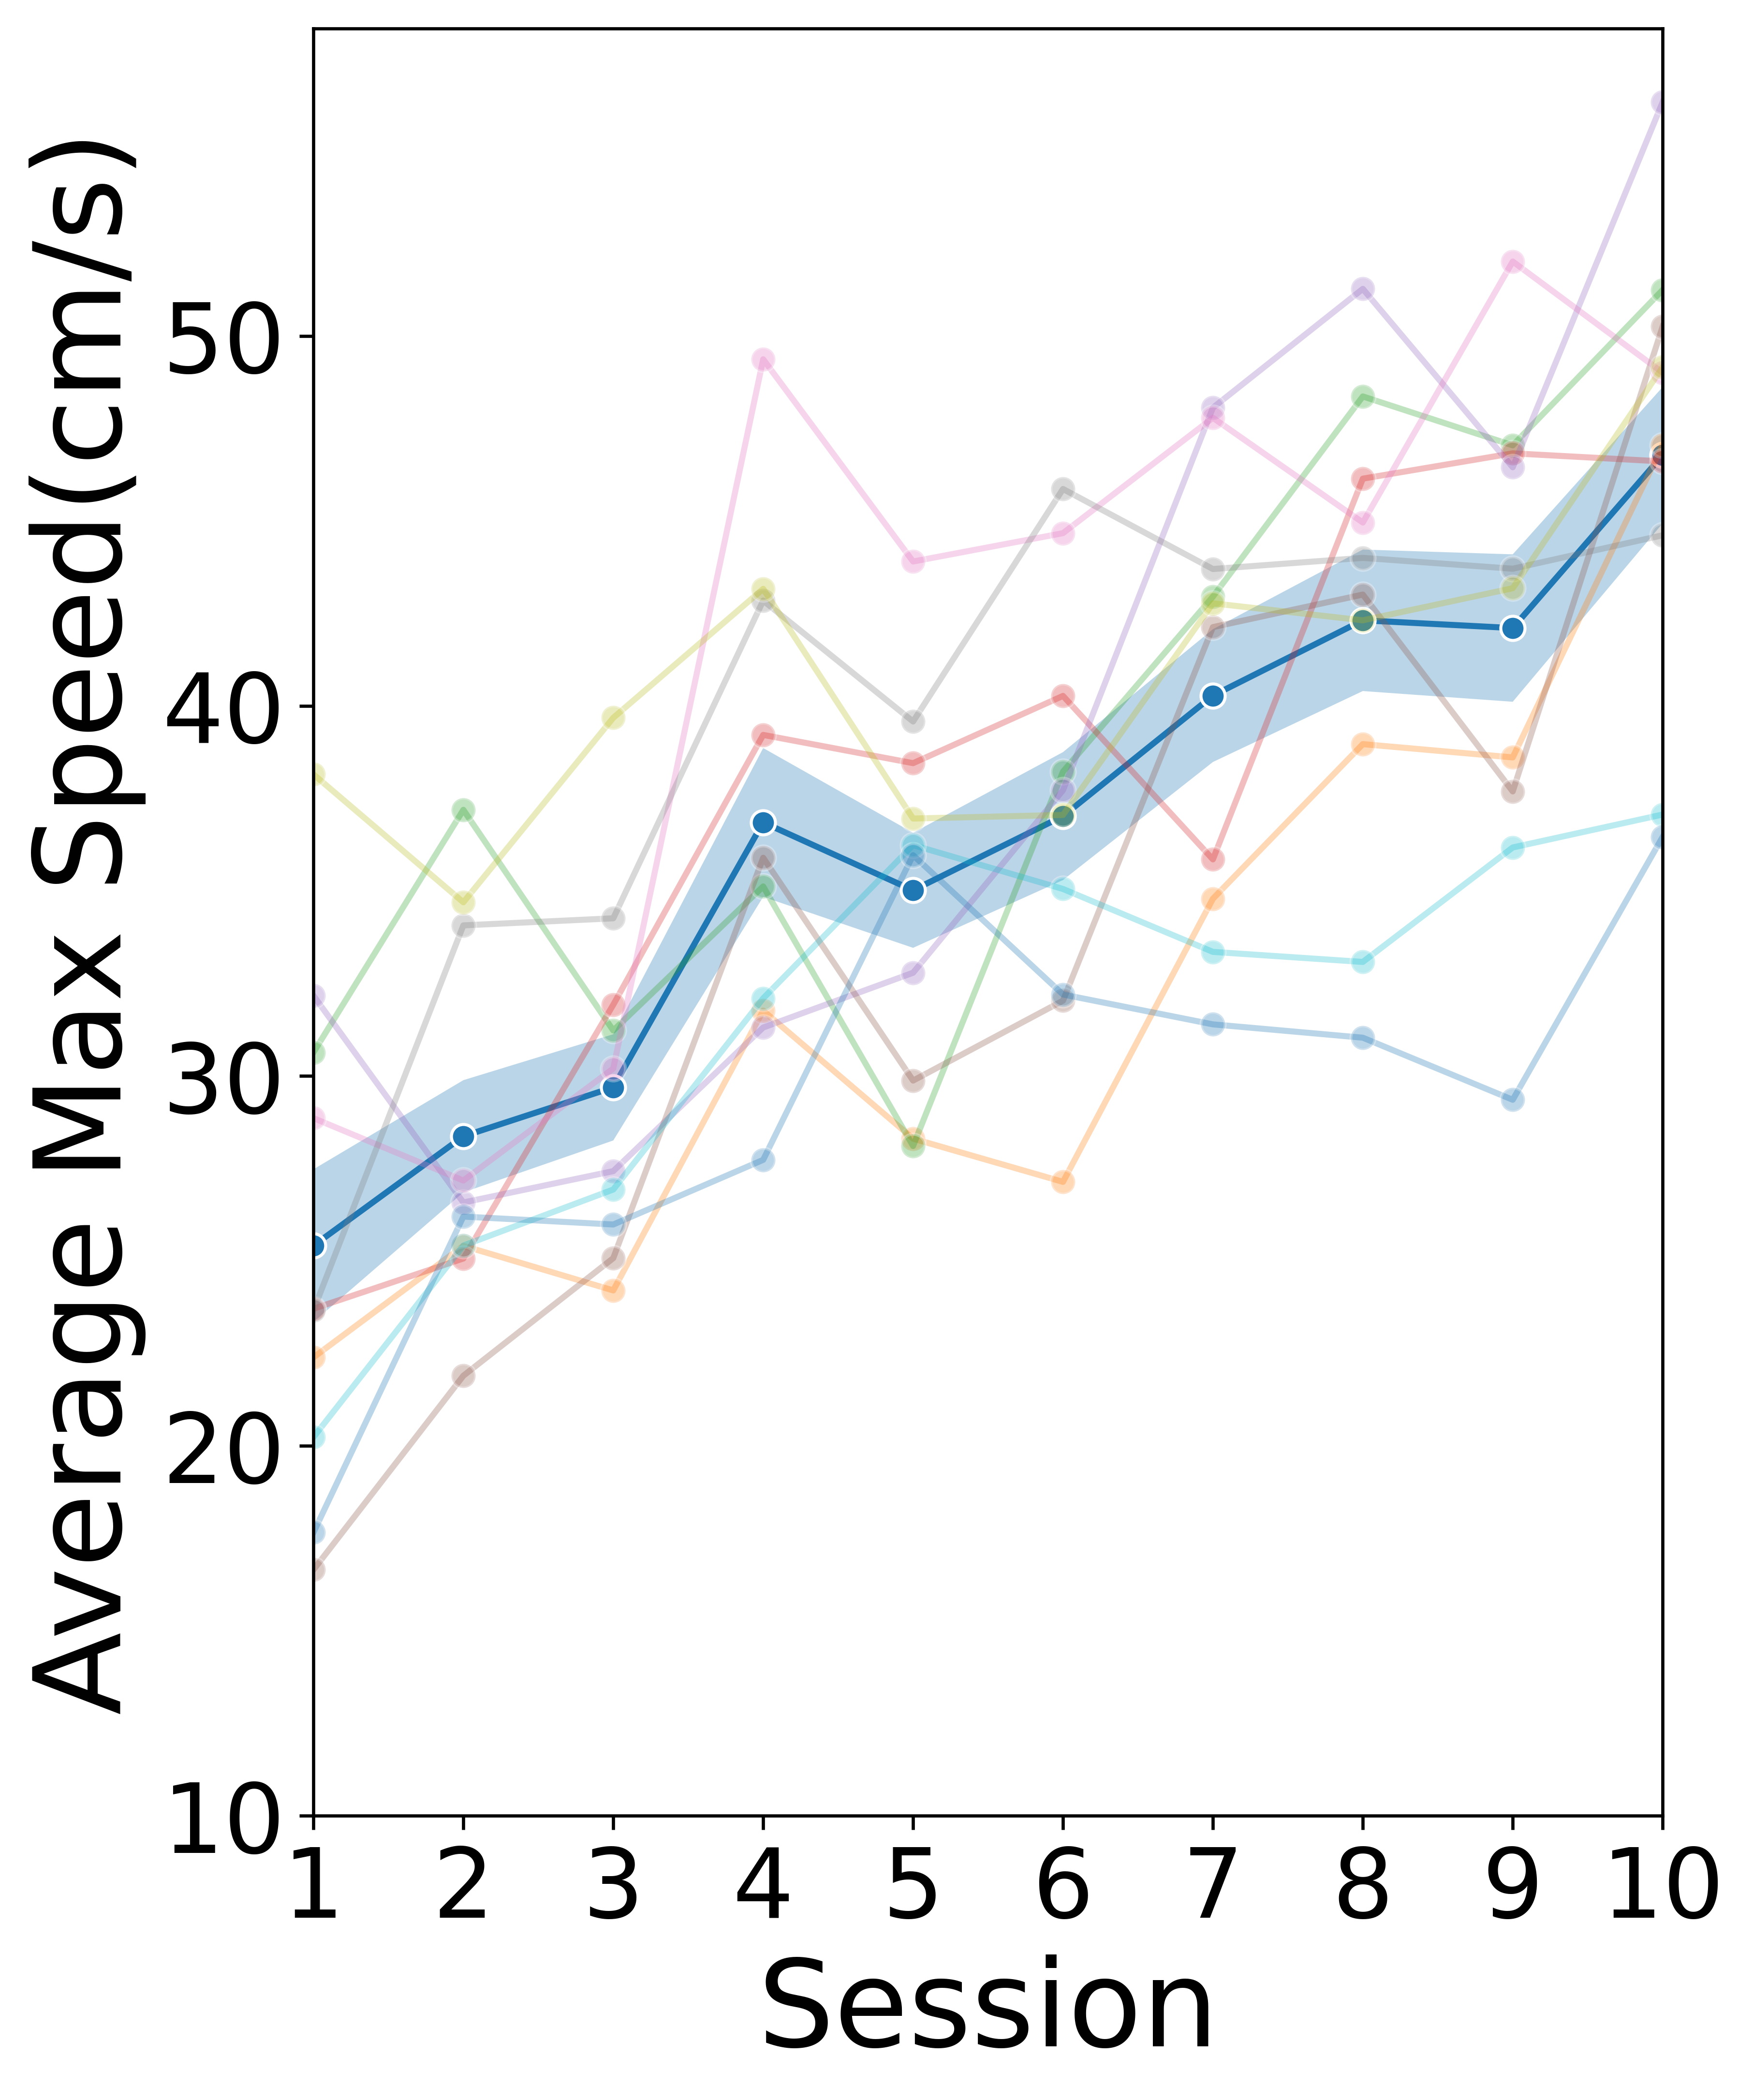

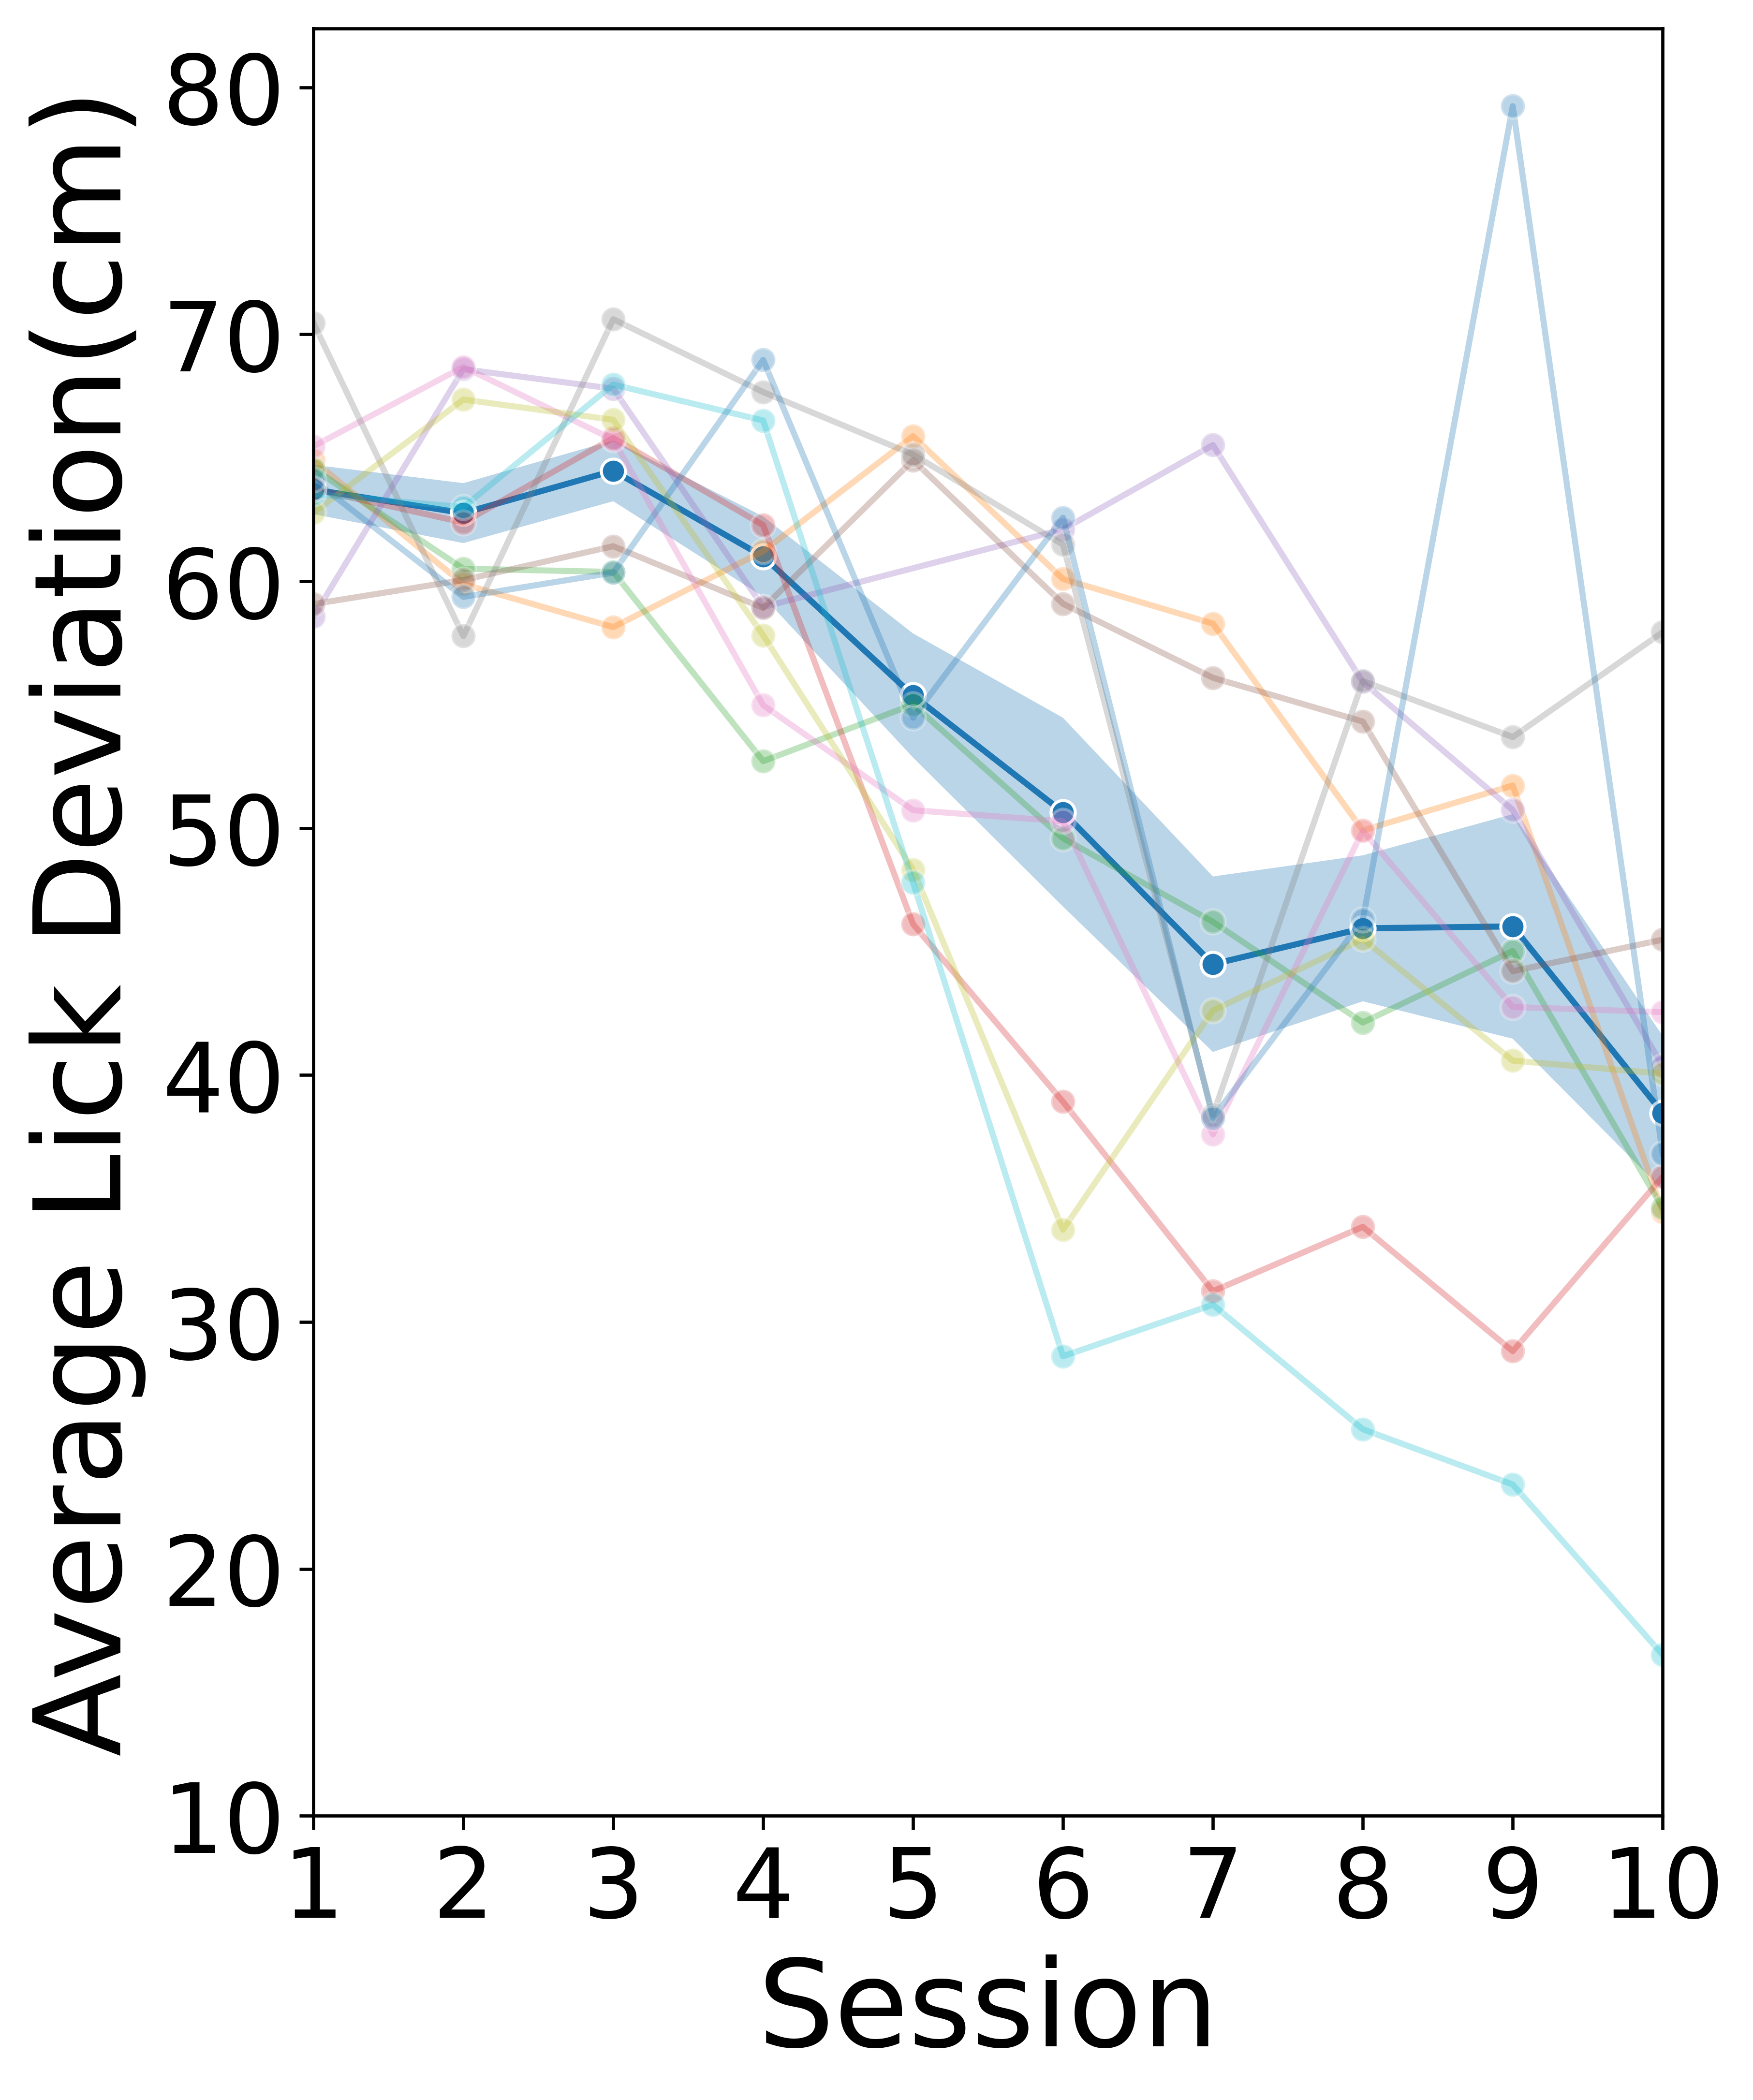

In [30]:
# evaluate_multiple_animal_training_performance
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# all_raw_df 是一個字典，key是動物的標識符，值是 DataFrame 的列表
keys = all_raw_df.keys()

# 初始化存儲結果的字典
avg_max_speeds = {}
df_dict = {}
avg_lick_deviation = {}
df_lick_deviation = {}

for key in keys:
    avg_max_speeds[key] = [calculate_avg_max_speed_in_a_session(df) for df in all_raw_df[key]]

    # 創建一個新的 DataFrame 來儲存結果
    df_dict[key] = pd.DataFrame({
        'Session': range(1, len(avg_max_speeds[key]) + 1),
        'Average Max Speed(cm/s)': avg_max_speeds[key]
    })

# 計算每個會話的平均值和SEM
num_sessions = max(len(speeds) for speeds in avg_max_speeds.values())
avg_speeds = []
sem_speeds = []

for session in range(num_sessions):
    session_speeds = [df_dict[key].iloc[session]['Average Max Speed(cm/s)'] for key in keys if session < len(df_dict[key])]
    avg_speeds.append(np.mean(session_speeds))
    sem_speeds.append(np.std(session_speeds) / np.sqrt(len(session_speeds)))

# 創建一個新的 DataFrame 來儲存結果
df_avg_speed = pd.DataFrame({
    'Session': range(1, num_sessions + 1),
    'Average Max Speed(cm/s)': avg_speeds,
    'SEM': sem_speeds
})

# 使用 seaborn 繪製帶有誤差帶的平均線
plt.figure(figsize=(6, 8), dpi=600)
sns.lineplot(x='Session', y='Average Max Speed(cm/s)', data=df_avg_speed, marker='o')
plt.fill_between(df_avg_speed['Session'], 
                 df_avg_speed['Average Max Speed(cm/s)'] - df_avg_speed['SEM'], 
                 df_avg_speed['Average Max Speed(cm/s)'] + df_avg_speed['SEM'], 
                 alpha=0.3)

#single animal trace
for key in keys:
    
    #  avg_lick_deviation[key] to DataFrame
    avg_max_speeds[key] = pd.DataFrame({
        'Session': range(1, len(avg_max_speeds[key]) + 1), 
        'Average Lick Deviation(cm)': avg_max_speeds[key]
    })
    sns.lineplot(x='Session', y='Average Lick Deviation(cm)', data=avg_max_speeds[key], marker='o', alpha=0.3)

# 設定座標軸的刻度
plt.xlim(left=1, right=num_sessions)
plt.xticks(np.arange(1, num_sessions+1 , step=1), size=24)
plt.yticks(size=24)
plt.xlabel('Session', size=30)
plt.ylabel('Average Max Speed(cm/s)', size=30)
plt.ylim(bottom=10)

# 設定圖表的標題
#plt.title('Daily Changes in Running Speed with SEM', size=20)

# 顯示圖表
plt.show()

for key in keys:
    # plot daily changes in lick deviation
    avg_lick_deviation[key] = [calculate_avg_lick_deviation_in_a_session(df, RzFloor, RzCeiling) for df in all_raw_df[key]]

    # 創建一個新的 DataFrame 來儲存結果
    df_lick_deviation[key] = pd.DataFrame({
        'Session': range(1, len(avg_lick_deviation[key]) + 1),
        'Average Lick Deviation(cm)': avg_lick_deviation[key]
    })

# 計算每個會話的平均值和SEM
num_sessions = max(len(deviations) for deviations in avg_lick_deviation.values())
avg_deviations = []
sem_deviations = []

for session in range(num_sessions):
    session_deviations = [df_lick_deviation[key].iloc[session]['Average Lick Deviation(cm)'] for key in keys if session < len(df_lick_deviation[key])]
    avg_deviations.append(np.nanmean(session_deviations))
    sem_deviations.append(np.nanstd(session_deviations) / np.sqrt(np.sum(~np.isnan(session_deviations))))

# 創建一個新的 DataFrame 來儲存結果
df_avg_deviation = pd.DataFrame({
    'Session': range(1, num_sessions + 1),
    'Average Lick Deviation(cm)': avg_deviations,
    'SEM': sem_deviations
})

# 使用 seaborn 繪製帶有誤差帶的平均線
plt.figure(figsize=(6, 8), dpi=600)
sns.lineplot(x='Session', y='Average Lick Deviation(cm)', data=df_avg_deviation, marker='o')
plt.fill_between(df_avg_deviation['Session'], 
                 df_avg_deviation['Average Lick Deviation(cm)'] - df_avg_deviation['SEM'], 
                 df_avg_deviation['Average Lick Deviation(cm)'] + df_avg_deviation['SEM'], 
                 alpha=0.3)

#single animal trace
for key in keys:
    
    #  avg_lick_deviation[key] to DataFrame
    avg_lick_deviation[key] = pd.DataFrame({
        'Session': range(1, len(avg_lick_deviation[key]) + 1), 
        'Average Lick Deviation(cm)': avg_lick_deviation[key]
    })
    sns.lineplot(x='Session', y='Average Lick Deviation(cm)', data=avg_lick_deviation[key], marker='o', alpha=0.3)

# 設定座標軸的刻度
plt.xlim(left=1, right=num_sessions)
plt.xticks(np.arange(1, num_sessions+1, step=1), size=24)
plt.yticks(size=24)
plt.xlabel('Session', size=30)
plt.ylabel('Average Lick Deviation(cm)', size=30)
plt.ylim(bottom=10)

# 設定圖表的標題
#plt.title('Daily Changes in Lick Deviation with SEM', size=20)

# 顯示圖表
plt.show()

In [4]:
#functions of plot test stage analysis
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def plot_behavior_trajectory(df, RzFloor, RzCeiling, file_name, save_path):

    # 設定圖表的大小與解析度
    plt.figure(figsize=(10, 6), dpi=600)

    # 繪製reward zone
    plt.axhspan(RzFloor, RzCeiling, color='cyan', alpha=0.75, label='Reward Zone')

    # 繪製RZ界線
    plt.axhline(y=RzFloor, color='blue', linestyle='dashed', linewidth=1)
    plt.axhline(y=RzCeiling, color='blue', linestyle='dashed', linewidth=1)

    # 繪製移動軌跡
    success_df, fail_df = Trial_success_and_fail(df, RzFloor, RzCeiling)
    if(len(success_df) > 0):
        plt.scatter(success_df[0] / (1000 * 60), success_df[2], color='lightgreen', s=0.5, label='success', marker = '_')
    if(len(fail_df) > 0):
        plt.scatter(fail_df[0] / (1000 * 60), fail_df[2], color='lightcoral', s=0.5, label='fail', marker = '_')

    # 繪製licking
    lick_happened = np.where(df[4].diff() != 0)[0]
    plt.scatter(df[0].iloc[lick_happened] / (1000 * 60), df[2].iloc[lick_happened], color='darkblue', s=0.5, label='lick')

    # 坐標軸標題
    plt.xlabel('Time (minutes)')
    plt.ylabel('Distance (cm)')

    # 設置圖形的原點位置
    plt.gca().spines['left'].set_position('zero')
    plt.gca().spines['bottom'].set_position('zero')

    # 設置軸範圍
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.ylim(0, 200)

    # 圖例
    plt.legend(scatterpoints=5, loc='upper right', prop={'size': 6})

    # 設定圖表的標題
    plt.title(file_name)
    # 儲存圖片到指定的路徑
    plt.savefig(save_path)
    plt.close()  # 關閉當前圖表以避免干擾


    
def plot_single_animal_speed_pattern(df, RzFloor, RzCeiling, smooth_window, path):

    # 過濾掉Distance大於RZceil的資料及速度小於5的資料
    df = df[(df[2] <= RzFloor + smooth_window-1 ) & (df[2] >= 0) & (df[3] <= 100) & (df[3] > 5)]

        # 讀取注射時間點
    injection, trial_injected = injection_at_which_trial(path)  

    if injection == True:
        df_before_injection = df[(df[1] >= int(trial_injected)-20) & (df[1] < int(trial_injected))]
        df_after_injection = df[(df[1] >= int(trial_injected)+10) & (df[1] < int(trial_injected)+30)]

        # 計算每個Trial中每X公分的速度平均值
        df_trial_avg_before_injection = df_before_injection.groupby([1, df[2] // smooth_window * smooth_window])[3].mean().reset_index()
        df_trial_avg_after_injection = df_after_injection.groupby([1, df[2] // smooth_window * smooth_window])[3].mean().reset_index()  

        # 計算每個位置上不同Trial的速度平均值和標準誤
        df_avg_before_injection = df_trial_avg_before_injection.groupby(2)[3].mean().reset_index()
        df_sem_before_injection = df_trial_avg_before_injection.groupby(2)[3].apply(sem).reset_index()

        df_avg_after_injection = df_trial_avg_after_injection.groupby(2)[3].mean().reset_index()
        df_sem_after_injection = df_trial_avg_after_injection.groupby(2)[3].apply(sem).reset_index()

        # 視覺化behavior trace
        plt.figure(figsize=(8, 6), dpi=600)

        # 設置RZ底色
        plt.axvspan(RzFloor, RzCeiling, facecolor='cyan', label='reward zone')

        # 繪製RZ界線
        plt.axvline(x=RzFloor, color='blue', linestyle='dashed', linewidth=1)
        plt.axvline(x=RzCeiling, color='blue', linestyle='dashed', linewidth=1)


        # 繪製折線圖
        plt.plot(df_avg_before_injection[2], df_avg_before_injection[3], marker='.', color = "black")


        # 添加誤差範圍
        Before_injection = plt.fill_between(df_avg_before_injection[2], df_avg_before_injection[3] - df_sem_before_injection[3], 
                                            df_avg_before_injection[3] + df_sem_before_injection[3], alpha=0.5, color = "black")


        # 繪製折線圖
        plt.plot(df_avg_after_injection[2], df_avg_after_injection[3], marker='.', color = "sandybrown")


        # 添加誤差範圍
        After_injection = plt.fill_between(df_avg_after_injection[2], df_avg_after_injection[3] - df_sem_after_injection[3], 
                                           df_avg_after_injection[3] + df_sem_after_injection[3], alpha=0.5, color = "sandybrown")

        # 添加標籤和標題
        plt.xlabel('Distance(cm)')
        plt.ylabel('Speed(cm/s)')
        plt.xlim(0, RzCeiling)
        plt.ylim(0)
        plt.legend([Before_injection, After_injection],['Before injection', 'After injection'], loc='upper right', prop={'size': 5})
        plt.title('Running speed')


    else:
        # 計算每個Trial中每X公分的速度平均值
        df_trial_avg = df.groupby([1, df[2] // smooth_window * smooth_window])[3].mean().reset_index()

        # 計算每個位置上不同Trial的速度平均值和標準誤
        df_avg = df_trial_avg.groupby(2)[3].mean().reset_index()
        df_sem = df_trial_avg.groupby(2)[3].apply(sem).reset_index()

        # 視覺化behavior trace
        plt.figure(figsize=(16, 9), dpi=600)

        # 設置RZ底色
        plt.axvspan(RzFloor, RzCeiling, facecolor='cyan', label='reward zone')

        # 繪製RZ界線
        plt.axvline(x=RzFloor, color='blue', linestyle='dashed', linewidth=1)
        plt.axvline(x=RzCeiling, color='blue', linestyle='dashed', linewidth=1)


        # 繪製折線圖
        plt.plot(df_avg[2], df_avg[3], marker='.', color = "red")


        # 添加誤差範圍
        plt.fill_between(df_avg[2], df_avg[3] - df_sem[3], df_avg[3] + df_sem[3], alpha=0.3, color = "red")


        # 添加標籤和標題
        plt.xlabel('Distance(cm)')
        plt.ylabel('Speed(cm/s)')
        plt.xlim(0, RzCeiling)
        plt.ylim(0)
        plt.title('Running speed')

def plot_lick_pattern(df, RzFloor, RzCeiling, smooth_window, path):
    
    # 讀取注射時間點
    injection, trial_injected = injection_at_which_trial(path)

    # 過濾掉Distance大於RZceil的資料
    df = df[(df[2] <= RzFloor+smooth_window-1) & (df[2] >= 0)]

    if injection == True:
        df_before_injection = df[(df[1] >= int(trial_injected)-20) & (df[1] < int(trial_injected))].copy()
        df_after_injection = df[(df[1] >= int(trial_injected)+10) & (df[1] < int(trial_injected)+30)].copy()

        # 重新標記lick是否發生的位置
        df_before_injection['Lick_occurred'] = df_before_injection[4].diff().ne(0).astype(int)
        df_after_injection['Lick_occurred'] = df_after_injection[4].diff().ne(0).astype(int)

        # 計算每個Trial中每X公分的lick發生次數平均值
        df_trial_avg_before_injection = df_before_injection.groupby([1, df_before_injection[2] // smooth_window * smooth_window])['Lick_occurred'].mean().reset_index()
        df_trial_avg_after_injection = df_after_injection.groupby([1, df_after_injection[2] // smooth_window * smooth_window])['Lick_occurred'].mean().reset_index()

        # 計算每個位置上不同Trial的lick次數平均值和標準誤
        df_avg_before_injection = df_trial_avg_before_injection.groupby(2)['Lick_occurred'].mean().reset_index()
        df_sem_before_injection = df_trial_avg_before_injection.groupby(2)['Lick_occurred'].apply(sem).reset_index()

        df_avg_after_injection = df_trial_avg_after_injection.groupby(2)['Lick_occurred'].mean().reset_index()
        df_sem_after_injection = df_trial_avg_after_injection.groupby(2)['Lick_occurred'].apply(sem).reset_index()

        #視覺化behavior trace
        plt.figure(figsize=(8, 6), dpi = 600)

        # 設置RZ底色
        plt.axvspan(RzFloor, RzCeiling, facecolor='cyan', label='reward zone')

        # 繪製RZ界線
        plt.axvline(x=RzFloor, color='blue', linestyle='dashed', linewidth=1)
        plt.axvline(x=RzCeiling, color='blue', linestyle='dashed', linewidth=1)



        # 繪製折線圖
        plt.plot(df_avg_before_injection[2], df_avg_before_injection['Lick_occurred'], marker='.', color = "black")

        # 添加誤差範圍
        Before_injection = plt.fill_between(df_avg_before_injection[2], df_avg_before_injection['Lick_occurred'] - df_sem_before_injection['Lick_occurred'], df_avg_before_injection['Lick_occurred'] + df_sem_before_injection['Lick_occurred'], alpha=0.5, color = "black")

        # 繪製折線圖
        plt.plot(df_avg_after_injection[2], df_avg_after_injection['Lick_occurred'], marker='.', color = "sandybrown")

        # 添加誤差範圍
        After_injection = plt.fill_between(df_avg_after_injection[2], df_avg_after_injection['Lick_occurred'] - df_sem_after_injection['Lick_occurred'], df_avg_after_injection['Lick_occurred'] + df_sem_after_injection['Lick_occurred'], alpha=0.5, color = "sandybrown")

        plt.legend([Before_injection, After_injection],['Before injection', 'After injection'], loc='upper right', prop={'size': 5})
    
    else:

        # 重新標記lick是否發生的位置
        df['Lick_occurred'] = df[4].diff().ne(0).astype(int)

        # 計算每個Trial中每X公分的lick發生次數平均值
        df_trial_avg = df.groupby([1, df[2] // smooth_window * smooth_window])['Lick_occurred'].sum().reset_index()

        # 計算每個位置上不同Trial的lick次數平均值和標準誤
        df_avg = df_trial_avg.groupby(2)['Lick_occurred'].mean().reset_index()
        df_sem = df_trial_avg.groupby(2)['Lick_occurred'].apply(sem).reset_index()

        #視覺化behavior trace
        plt.figure(figsize=(16,9), dpi = 600)

        # 設置RZ底色
        plt.axvspan(RzFloor, RzCeiling, facecolor='cyan', label='reward zone')

        # 繪製RZ界線
        plt.axvline(x=RzFloor, color='blue', linestyle='dashed', linewidth=1)
        plt.axvline(x=RzCeiling, color='blue', linestyle='dashed', linewidth=1)


        # 繪製折線圖
        plt.plot(df_avg[2], df_avg['Lick_occurred'], marker='.', color = "red")


        # 添加誤差範圍
        plt.fill_between(df_avg[2], df_avg['Lick_occurred'] - df_sem['Lick_occurred'], df_avg['Lick_occurred'] + df_sem['Lick_occurred'], alpha=0.3, color = "red")



    # 添加標籤和標題
    plt.xlabel('Distance(cm)')
    plt.ylabel('Licking(times)')
    plt.title('Spatial frequency of licks')

    # 顯示圖形
    plt.xlim(5, RzCeiling)
    plt.ylim(0,3)


In [7]:
#plot_and_save_behavior_trajectory
for i, df in enumerate(all_raw_df.values()):
    save_path = data_file_paths[i].replace('.csv', '_behavior_trajectory.png')
    plot_behavior_trajectory(df, RzFloor, RzCeiling, file_names[i], save_path)

In [5]:
#(函數)licking_statistic plot
def licking_statistic_bar_plot(mean_before, sem_before, mean_after, sem_after, All_individual_data_point, plot_title, save_fig, plot_save_dir, ylim, yaxis_label):
    # 創建柱狀圖

    bar_width = 0.5
    opacity = 0.5
    error_config = {'elinewidth' : 2, 
                    'capsize' : 8}
    
    plt.figure(figsize=(5, 8))

    plt.bar(0, mean_before, bar_width/3,
                    alpha=opacity, color='black', edgecolor='black',linewidth=2,
                    yerr=sem_before, error_kw=error_config,
                    label='Before Injection')

    plt.bar(bar_width/1.8, mean_after, bar_width/3,
                    alpha=opacity, color='sandybrown', edgecolor='sandybrown',linewidth=2,
                    yerr=sem_after, error_kw=error_config,
                    label='After Injection')

    # 在柱狀圖上添加數據點
    plt.scatter(np.full(len(All_individual_data_point['PreTx']), 0), All_individual_data_point['PreTx'], color='black', s=72)
    plt.scatter(np.full(len(All_individual_data_point['PostTx']), bar_width/1.8), All_individual_data_point['PostTx'], color='sandybrown', s=72)

    # 畫出配對的線
    for i in range(len(All_individual_data_point['PreTx'])):
        plt.plot([0, bar_width/1.8], [All_individual_data_point['PreTx'][i], All_individual_data_point['PostTx'][i]], 'k-')

    # 設定圖形的背景色和坐標軸標籤
    plt.ylabel(yaxis_label, fontsize=36)
    #plt.title(plot_title, fontsize=16)
    plt.xticks([0, bar_width/1.8], ['Before', 'After'], fontsize=36)
    plt.legend(loc='upper left', fontsize=18)
    plt.yticks(fontsize=30)
    plt.ylim(0, ylim)


    if save_fig == True:
        plt.savefig(plot_save_dir + '/' + plot_title + ".jpg", dpi=600, bbox_inches='tight')

    plt.show()


#(函數)計算每個Trial中licking event發生位置的mean, var, std
def licking_statistic(all_raw_df, index):
    raw_df = all_raw_df[index]
    raw_df = raw_df.dropna()
    trial_df = raw_df.groupby(raw_df.columns[1])
    All_trial_licks = {}

    for trial_number, group_data in trial_df:

        # 找出 Licking_count 出現變化的行
        Licking_rows = group_data[group_data[4].diff() != 0]
        Licking_rows = Licking_rows.drop(Licking_rows.index[0])
        if (len(Licking_rows.loc[Licking_rows[2] >= 150])-len(Licking_rows.loc[Licking_rows[2] >= 170])) > 0:
            first_lick_in_RZ = Licking_rows.loc[Licking_rows[2] >= 150].iloc[0]
            first_lick_in_RZ = pd.DataFrame(first_lick_in_RZ)
            first_lick_in_RZ = first_lick_in_RZ.T
            Licking_rows = Licking_rows.loc[group_data[2] < RzFloor]
            Licking_rows = Licking_rows.loc[group_data[2] > lick_position_threshold]
            Licking_rows = pd.concat([Licking_rows, first_lick_in_RZ], axis=0, ignore_index=True)
            trial_success = True

        else :
            Licking_rows = Licking_rows.loc[group_data[2] < RzFloor]
            Licking_rows = Licking_rows.loc[group_data[2] > lick_position_threshold]
            trial_success = False
        
        if len(Licking_rows) == 0:
            lick_mean = pd.NA
            lick_var = pd.NA
            lick_std = pd.NA
            lick_cv = pd.NA
            

        elif len(Licking_rows) == 1:
            lick_mean = RzFloor
            lick_var = 0
            lick_std = 0
            lick_cv = 0
            
        else:
            lick_mean = round(Licking_rows[2].mean(), 2)
            lick_var = round(Licking_rows[2].var(), 2)
            lick_std = round(Licking_rows[2].std(), 2)
            lick_cv = round(Licking_rows[2].std() / Licking_rows[2].mean(), 2)

        All_trial_licks[int(trial_number)] = {"success":trial_success, "mean": lick_mean,"var": lick_var,"std": lick_std, "cv": lick_cv}

    All_trial_licks = pd.DataFrame(All_trial_licks)
    All_trial_licks = All_trial_licks.T
    All_trial_licks = All_trial_licks.sort_index()

    return All_trial_licks

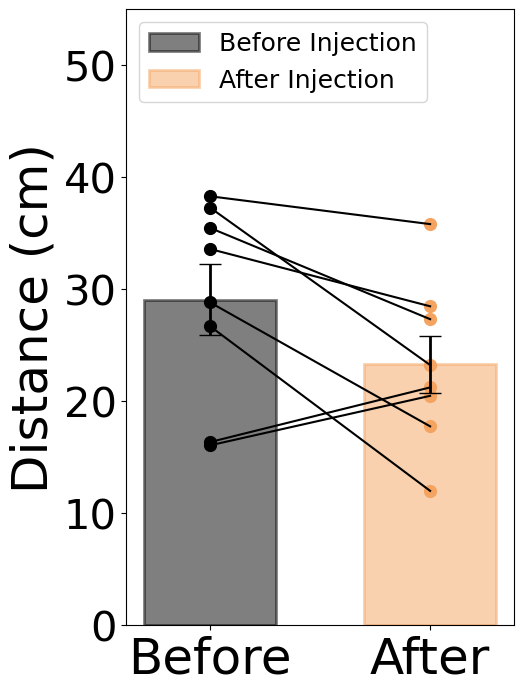

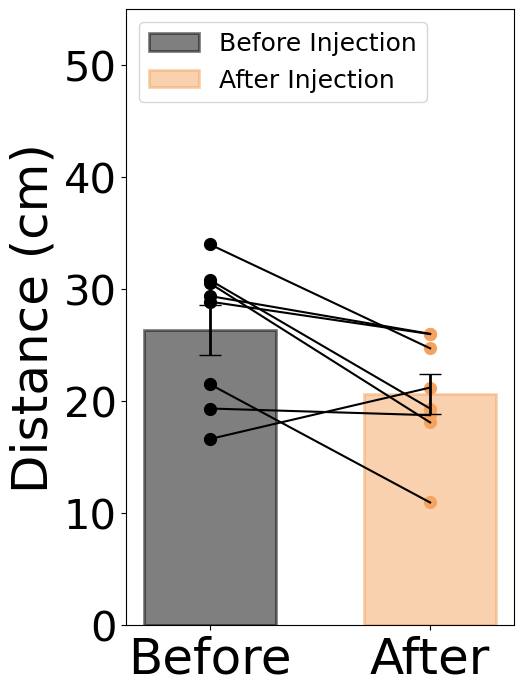

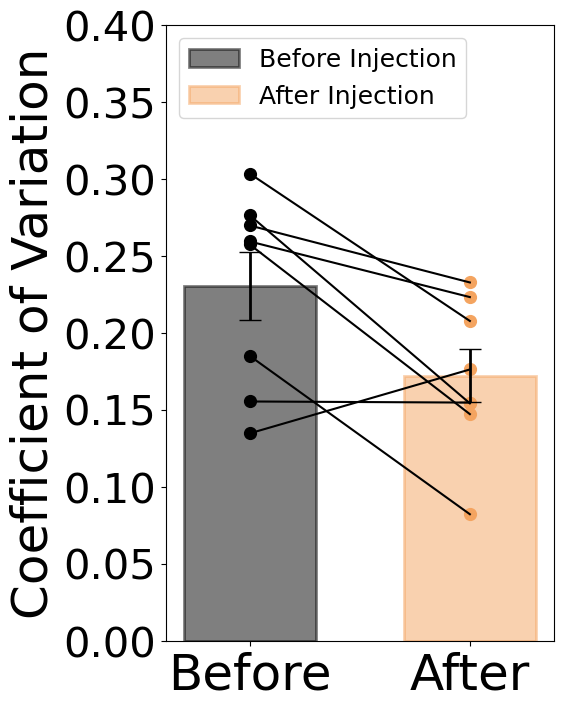

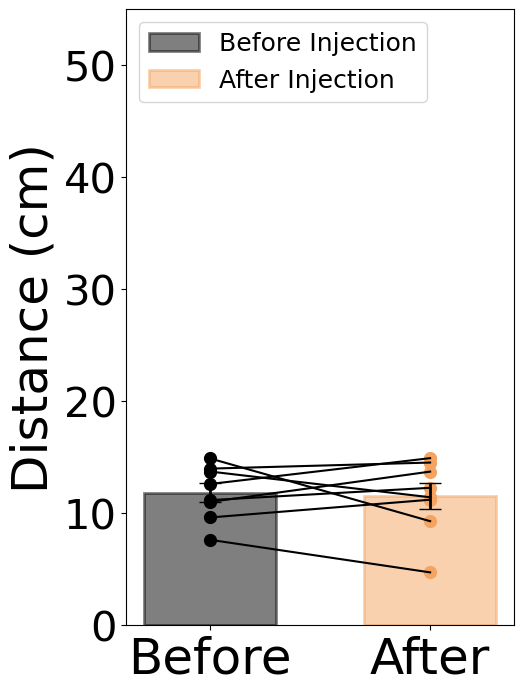

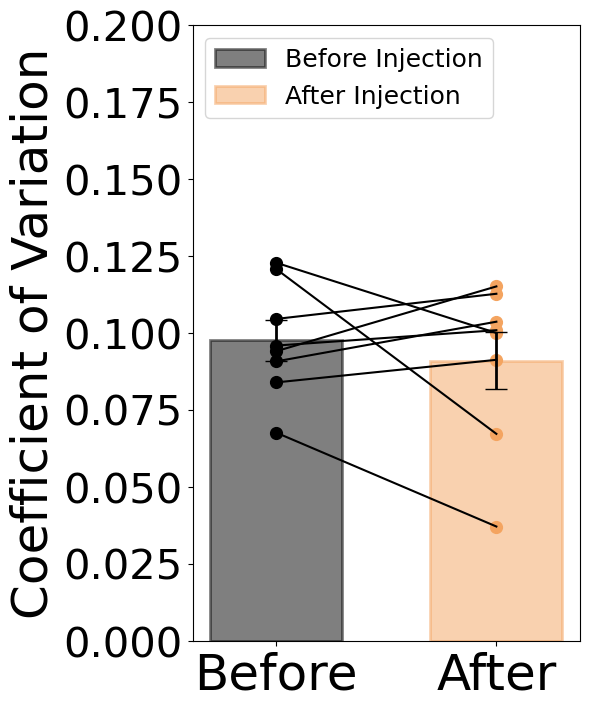

In [ ]:
#licking_statistic plot
import matplotlib.pyplot as plt
import numpy as np

save_fig = True

if save_fig == True:
    root = Tk()
    root.attributes('-topmost', True)  # 將主視窗設置為最上層
    root.withdraw()

    plot_save_dir = filedialog.askdirectory(parent=root, title='選擇plot儲存位置')
    basename = os.path.basename(plot_save_dir)  # such as '2000ng'
    dirname = os.path.basename(os.path.dirname(plot_save_dir))  # such as 'muscle injection'

    treatment = dirname + '_' + basename + '_' + schedule
    

All_individual_mean = pd.DataFrame(columns=['PreTx', 'PostTx', 'delta_mean'])
All_individual_var = pd.DataFrame(columns=['PreTx', 'PostTx'])
All_individual_std = pd.DataFrame(columns=['PreTx', 'PostTx'])
All_std_btween_trial = pd.DataFrame(columns=['PreTx','PostTx'])
All_individual_cv = pd.DataFrame(columns=['PreTx', 'PostTx', 'delta_cv'])
All_cv_btween_trial = pd.DataFrame(columns=['PreTx', 'PostTx', 'delta_cv'])

for index, data_file_dir in enumerate(data_file_paths):
    licking_statistic_df_temp = licking_statistic(all_raw_df, index)

    #找到注射前，第1到30成功Trial的，licking_statistic，並計算個體平均、變異數、標準差
    licking_statistic_df_before_injection = licking_statistic_df_temp.iloc[0:30]
    licking_statistic_df_before_injection = licking_statistic_df_before_injection[licking_statistic_df_before_injection['success'] == True]
    licking_statistic_df_before_injection = licking_statistic_df_before_injection.reset_index(drop=True)
    All_individual_mean.loc[index, 'PreTx'] = licking_statistic_df_before_injection['mean'].mean()
    All_individual_var.loc[index, 'PreTx'] = licking_statistic_df_before_injection['var'].mean()
    All_individual_std.loc[index, 'PreTx'] = licking_statistic_df_before_injection['std'].mean()
    All_individual_cv.loc[index, 'PreTx'] = licking_statistic_df_before_injection['cv'].mean()
    All_std_btween_trial.loc[index, 'PreTx'] = licking_statistic_df_before_injection['mean'].std()
    All_cv_btween_trial.loc[index, 'PreTx'] = licking_statistic_df_before_injection['mean'].std()/licking_statistic_df_before_injection['mean'].mean()

    #找到注射後，第30後成功Trial的，licking_statistic，並計算個體平均、變異數、標準差
    licking_statistic_df_after_injection = licking_statistic_df_temp.iloc[31:]
    licking_statistic_df_after_injection = licking_statistic_df_after_injection.reset_index(drop=True)
    licking_statistic_df_after_injection = licking_statistic_df_after_injection[licking_statistic_df_after_injection['success'] == True]
    licking_statistic_df_after_injection = licking_statistic_df_after_injection.iloc[10:30]
    licking_statistic_df_after_injection = licking_statistic_df_after_injection.reset_index(drop=True)
    All_individual_mean.loc[index, 'PostTx'] = licking_statistic_df_after_injection['mean'].mean()
    All_individual_var.loc[index, 'PostTx'] = licking_statistic_df_after_injection['var'].mean()
    All_individual_std.loc[index, 'PostTx'] = licking_statistic_df_after_injection['std'].mean()
    All_std_btween_trial.loc[index, 'PostTx'] = licking_statistic_df_after_injection['mean'].std()
    All_individual_cv.loc[index, 'PostTx'] = licking_statistic_df_after_injection['cv'].mean()
    All_cv_btween_trial.loc[index, 'PostTx'] = licking_statistic_df_after_injection['mean'].std()/licking_statistic_df_after_injection['mean'].mean()
    All_individual_mean.loc[index, 'delta_mean'] = All_individual_mean.loc[index, 'PreTx'] - All_individual_mean.loc[index, 'PostTx']
    All_individual_cv.loc[index, 'delta_cv'] = All_individual_cv.loc[index, 'PostTx'] - All_individual_cv.loc[index, 'PreTx'] 
    All_cv_btween_trial.loc[index, 'delta_cv'] = All_cv_btween_trial.loc[index, 'PostTx'] - All_cv_btween_trial.loc[index, 'PreTx']

for column in All_individual_mean.columns:
    All_individual_mean[column] = pd.to_numeric(All_individual_mean[column], errors='coerce')

for column in All_individual_var.columns:
    All_individual_var[column] = pd.to_numeric(All_individual_var[column], errors='coerce')

for column in All_individual_cv.columns:
    All_individual_cv[column] = pd.to_numeric(All_individual_cv[column], errors='coerce')

for column in All_individual_std.columns:
    All_individual_std[column] = pd.to_numeric(All_individual_std[column], errors='coerce')

for column in All_std_btween_trial.columns:
    All_std_btween_trial[column] = pd.to_numeric(All_std_btween_trial[column], errors='coerce')

for column in All_cv_btween_trial.columns:
    All_cv_btween_trial[column] = pd.to_numeric(All_cv_btween_trial[column], errors='coerce')   

# 計算個體平均的平均值和標準誤
mean_before = -(All_individual_mean['PreTx'].nlargest(20).mean()-150)
mean_after = -(All_individual_mean['PostTx'].nlargest(20).mean()-150)
sem_before = All_individual_mean['PreTx'].nsmallest(20).sem()
sem_after = All_individual_mean['PostTx'].nsmallest(20).sem()



plot_title = treatment+'_mean'
licking_statistic_bar_plot(mean_before, sem_before, mean_after, sem_after, -(All_individual_mean-150), plot_title, save_fig, plot_save_dir, 55, 'Distance (cm)')


# 計算個體標準差的平均值和標準誤
mean_before = All_individual_std['PreTx'].nsmallest(20).mean()
mean_after = All_individual_std['PostTx'].nsmallest(20).mean()
sem_before = All_individual_std['PreTx'].nsmallest(20).sem()
sem_after = All_individual_std['PostTx'].nsmallest(20).sem()

plot_title = treatment+'_std_wtihin_trial'
licking_statistic_bar_plot(mean_before, sem_before, mean_after, sem_after, All_individual_std, plot_title, save_fig, plot_save_dir, 55, 'Distance (cm)')

# CV plot
mean_before = All_individual_cv['PreTx'].nsmallest(20).mean()
mean_after = All_individual_cv['PostTx'].nsmallest(20).mean()
sem_before = All_individual_cv['PreTx'].nsmallest(20).sem()
sem_after = All_individual_cv['PostTx'].nsmallest(20).sem()

plot_title = treatment+'_cv_wtihin_trial'
licking_statistic_bar_plot(mean_before, sem_before, mean_after, sem_after, All_individual_cv, plot_title, save_fig, plot_save_dir, 0.4, 'Coefficient of Variation')

# 計算個體Trial間標準差的平均值和標準誤
mean_before = All_std_btween_trial['PreTx'].nsmallest(20).mean()
mean_after = All_std_btween_trial['PostTx'].nsmallest(20).mean()
sem_before = All_std_btween_trial['PreTx'].nsmallest(20).sem()
sem_after = All_std_btween_trial['PostTx'].nsmallest(20).sem()

plot_title = treatment+'_std_btween_trial'
licking_statistic_bar_plot(mean_before, sem_before, mean_after, sem_after, All_std_btween_trial, plot_title, save_fig, plot_save_dir, 55, 'Distance (cm)')

# 計算個體Trial間CV的平均值和標準誤
mean_before = All_cv_btween_trial['PreTx'].nsmallest(20).mean()
mean_after = All_cv_btween_trial['PostTx'].nsmallest(20).mean()
sem_before = All_cv_btween_trial['PreTx'].nsmallest(20).sem()
sem_after = All_cv_btween_trial['PostTx'].nsmallest(20).sem()

plot_title = treatment+'_cv_btween_trial'
licking_statistic_bar_plot(mean_before, sem_before, mean_after, sem_after, All_cv_btween_trial, plot_title, save_fig, plot_save_dir, 0.2, 'Coefficient of Variation')



In [147]:
#extract the data of each condition
index = 26
lick_data_in_each_condiction.loc[index, 'condiction_name'] = 'ip_400ug_ctl_saline'
lick_data_in_each_condiction.loc[index, 'mean_of_dalta_COM_mean'] = All_individual_mean['delta_mean'].mean()
lick_data_in_each_condiction.loc[index, 'sem_of_dalta_COM_mean']   = All_individual_mean['delta_mean'].sem()
lick_data_in_each_condiction.loc[index, 'mean_of_dalta_COM_CV_within_trial'] = All_individual_cv['delta_cv'].mean()
lick_data_in_each_condiction.loc[index, 'sem_of_dalta_COM_CV_within_trial'] = All_individual_cv['delta_cv'].sem()
lick_data_in_each_condiction.loc[index, 'mean_of_dalta_COM_CV_across_trial'] = All_cv_btween_trial['delta_cv'].mean()
lick_data_in_each_condiction.loc[index, 'sem_of_dalta_COM_CV_across_trial'] = All_cv_btween_trial['delta_cv'].sem()

#save the data
lick_data_in_each_condiction.to_csv(r'C:\Users\Meng-Xuan Liu\Desktop\lick_data_in_each_condiction.csv', index=False)

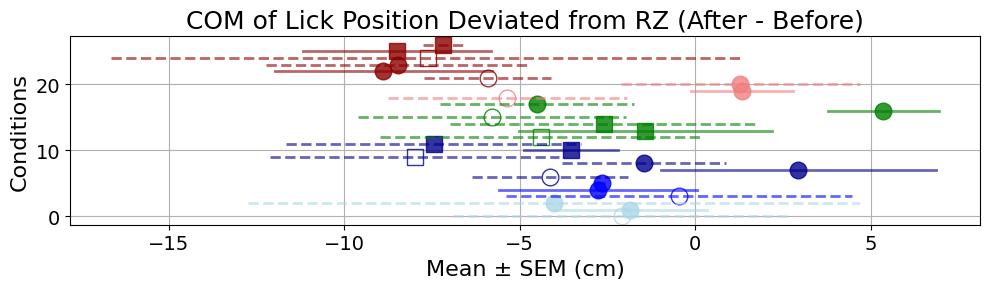

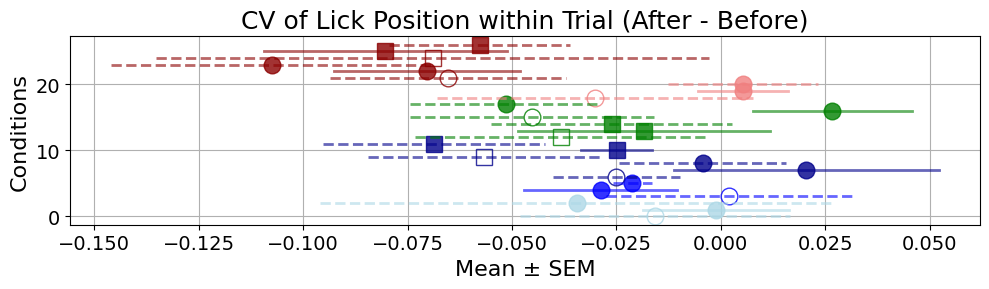

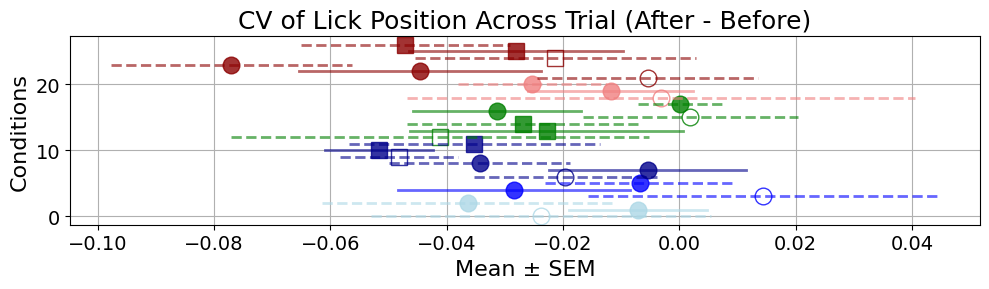

In [ ]:
#plot the data across different conditions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
new_file_path_latest = r"G:\works\Data_archive\Treadmill_task\Grouped_Data\lick_data_in_each_condiction_2710160747.csv"
new_data_latest = pd.read_csv(new_file_path_latest)

# Prepare y-axis values for plotting
y_values_latest = np.arange(len(new_data_latest))

# Functions for marker, color, and linestyle selection based on condition
def get_marker_style_and_color_v2_fixed(condiction_name):
    if 'imdistallimb' in condiction_name:  # i.m. distal limb muscles
        if 'PL' in condiction_name:
            if '2' in condiction_name:
                return ('o', 'lightblue', '--')  # Light blue for PL baseline (open circle)
            elif '4' in condiction_name:
                return ('o', 'blue', '-')  # Medium blue for PL saline (filled circle)
            else:  # CTZ with different doses
                return ('o', 'darkblue', '-')  # Dark blue for PL CTZ (filled circle)
        elif 'Ctl' in condiction_name:
            if '2' in condiction_name:
                return ('s', 'lightblue', '--')  # Light blue for Ctl baseline (open square)
            elif '4' in condiction_name:
                return ('s', 'blue', '-')  # Medium blue for Ctl saline (filled square)
            else:  # CTZ with different doses
                return ('s', 'darkblue', '-')  # Dark blue for Ctl CTZ (filled square)
    
    elif 'improximallimb' in condiction_name:  # i.m. proximal limb muscles
        if 'PL' in condiction_name:
            if 'baseline' in condiction_name:
                return ('o', 'green', '--')  # Light green for PL baseline (open circle)
            elif 'saline' in condiction_name:
                return ('o', 'green', '-')  # Medium green for PL saline (filled circle)
            else:  # CTZ with different doses
                return ('o', 'green', '-')  # Dark green for PL CTZ (filled circle)
        elif 'Ctl' in condiction_name:
            if 'baseline' in condiction_name:
                return ('s', 'green', '--')  # Light green for Ctl baseline (open square)
            elif 'saline' in condiction_name:
                return ('s', 'green', '-')  # Medium green for Ctl saline (filled square)
            else:  # CTZ with different doses
                return ('s', 'green', '-')  # Dark green for Ctl CTZ (filled square)
    
    elif 'ip' in condiction_name:  # i.p. injection
        if 'PL' in condiction_name:
            if '100' in condiction_name:
                return ('o', 'lightcoral', '--')  # Light coral for PL baseline (open circle)
            else:  # CTZ with different doses
                return ('o', 'darkred', '-')  # Dark red for PL CTZ (filled circle)
        elif 'Ctl' in condiction_name:
            if '100' in condiction_name:
                return ('s', 'lightcoral', '--')  # Light coral for Ctl baseline (open square)
            else:  # CTZ with different doses
                return ('s', 'darkred', '-')  # Dark red for Ctl CTZ (filled square)

    return ('o', 'gray', '-')  # Default marker for unknown conditions

def get_error_line_style_v2(condiction_name):
    if 'baseline' in condiction_name or 'saline' in condiction_name:
        return '--'  # Dashed line for baseline and saline error bars
    else:
        return '-'  # Solid line for CTZ and others

def plot_custom_style(mean_col, sem_col, title, xlabel):
    plt.figure(figsize=(10, 3))  # 調整圖形的寬度和高度，使圖形變得更扁
    for i, row in new_data_latest.iterrows():
        marker, color, linestyle = get_marker_style_and_color_v2_fixed(row['condiction_name'])
        error_linestyle = get_error_line_style_v2(row['condiction_name'])
        
        # 繪製數據點
        if 'baseline' in row['condiction_name']:
            plt.plot(row[mean_col], y_values_latest[i], marker=marker, color=color, markerfacecolor='none', markersize=12, linestyle='None', alpha=0.8)
        else:
            plt.plot(row[mean_col], y_values_latest[i], marker=marker, color=color, markerfacecolor=color, markersize=12, linestyle='None', alpha=0.8)
        
    # 繪製誤差棒
    for i, row in new_data_latest.iterrows():
        marker, color, linestyle = get_marker_style_and_color_v2_fixed(row['condiction_name'])
        error_linestyle = get_error_line_style_v2(row['condiction_name'])
        plt.plot([row[mean_col] - row[sem_col], row[mean_col] + row[sem_col]], 
                 [y_values_latest[i], y_values_latest[i]], 
                 linestyle=error_linestyle, color=color, linewidth=2, alpha=0.6)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Conditions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Measures and labels for plotting
final_measures = [
    ("mean_COM Deviated from RZ: After-Before", "sem_COM Deviated from RZ: After-Before", "COM of Lick Position Deviated from RZ (After - Before)", "Mean ± SEM (cm)"),
    ("mean_CV of Lick Position within Trial: After-Before", "sem_of_CV of Lick Position within Trial: After-Before", "CV of Lick Position within Trial (After - Before)", "Mean ± SEM"),
    ("mean_CV of Lick Position Across Trial: After-Before", "sem_CV of Lick Position Across Trial: After-Before", "CV of Lick Position Across Trial (After - Before)", "Mean ± SEM")
]

plt.rcParams['axes.titlesize'] = 18  # 設置標題字體大小
plt.rcParams['axes.labelsize'] = 16  # 設置坐標軸標籤字體大小
plt.rcParams['xtick.labelsize'] = 14  # 設置 x 軸刻度標籤字體大小
plt.rcParams['ytick.labelsize'] = 14  # 設置 y 軸刻度標籤字體大小

# Plot all measures with the custom styling
for mean_col, sem_col, title, xlabel in final_measures:
    plot_custom_style(mean_col, sem_col, title, xlabel)

In [21]:
# Permutation Test Plot
import pandas as pd
import dabest
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog
import os

# # 是否保存圖表
# save_fig = True

# if save_fig:
#     root = Tk()
#     root.attributes('-topmost', True)  # 將主視窗設置為最上層
#     root.withdraw()

#     plot_save_dir = filedialog.askdirectory(parent=root, title='選擇plot儲存位置')
#     basename = os.path.basename(plot_save_dir)  # 如 '2000ng'
#     dirname = os.path.basename(os.path.dirname(plot_save_dir))  # 如 'muscle injection'

#     treatment = f"{dirname}_{basename}_schedule"

# 建立空的數據框以存儲結果
All_individual_mean = pd.DataFrame(columns=['PreTx', 'PostTx'])
All_individual_var = pd.DataFrame(columns=['PreTx', 'PostTx'])
All_individual_std = pd.DataFrame(columns=['PreTx', 'PostTx'])
All_std_btween_trial = pd.DataFrame(columns=['PreTx', 'PostTx'])
All_individual_cv = pd.DataFrame(columns=['PreTx', 'PostTx'])
All_cv_btween_trial = pd.DataFrame(columns=['PreTx', 'PostTx'])


# 逐個處理數據
for index, data_file_dir in enumerate(data_file_paths):
    licking_statistic_df_temp = licking_statistic(all_raw_df, index)

    # 注射前數據
    licking_statistic_df_before_injection = licking_statistic_df_temp.iloc[0:30]
    licking_statistic_df_before_injection = licking_statistic_df_before_injection[licking_statistic_df_before_injection['success'] == True]
    licking_statistic_df_before_injection = licking_statistic_df_before_injection.reset_index(drop=True)
    All_individual_mean.loc[index, 'PreTx'] = licking_statistic_df_before_injection['mean'].mean()
    All_individual_var.loc[index, 'PreTx'] = licking_statistic_df_before_injection['var'].mean()
    All_individual_std.loc[index, 'PreTx'] = licking_statistic_df_before_injection['std'].mean()
    All_individual_cv.loc[index, 'PreTx'] = licking_statistic_df_before_injection['cv'].mean()
    All_std_btween_trial.loc[index, 'PreTx'] = licking_statistic_df_before_injection['mean'].std()
    All_cv_btween_trial.loc[index, 'PreTx'] = licking_statistic_df_before_injection['mean'].std() / licking_statistic_df_before_injection['mean'].mean()

    # 注射後數據
    licking_statistic_df_after_injection = licking_statistic_df_temp.iloc[31:]
    licking_statistic_df_after_injection = licking_statistic_df_after_injection.reset_index(drop=True)
    licking_statistic_df_after_injection = licking_statistic_df_after_injection[licking_statistic_df_after_injection['success'] == True]
    licking_statistic_df_after_injection = licking_statistic_df_after_injection.iloc[10:30]
    licking_statistic_df_after_injection = licking_statistic_df_after_injection.reset_index(drop=True)
    All_individual_mean.loc[index, 'PostTx'] = licking_statistic_df_after_injection['mean'].mean()
    All_individual_var.loc[index, 'PostTx'] = licking_statistic_df_after_injection['var'].mean()
    All_individual_std.loc[index, 'PostTx'] = licking_statistic_df_after_injection['std'].mean()
    All_std_btween_trial.loc[index, 'PostTx'] = licking_statistic_df_after_injection['mean'].std()
    All_individual_cv.loc[index, 'PostTx'] = licking_statistic_df_after_injection['cv'].mean()
    All_cv_btween_trial.loc[index, 'PostTx'] = licking_statistic_df_after_injection['mean'].std() / licking_statistic_df_after_injection['mean'].mean()
    All_individual_mean.loc[index, 'delta_mean'] = All_individual_mean.loc[index, 'PreTx'] - All_individual_mean.loc[index, 'PostTx']

# 轉換數據格式為 dabest 可接受的格式
long_data = All_individual_mean.melt(
    id_vars=[],
    var_name="Condition",
    value_name="Lick Position COM deviates from RZ"
).reset_index()

# # 加入 Mice_id 
# long_data["Mice_id"] = (long_data.index % (len(long_data) // 2))

# # 將 Value 轉換為數值
# long_data["Lick Position COM deviates from RZ"] = pd.to_numeric(long_data["Lick Position COM deviates from RZ"], errors="coerce")
# long_data["Lick Position COM deviates from RZ"] = 150 - long_data["Lick Position COM deviates from RZ"]


# Permutation Test Plot 函數
def permutation_test_plot(data, idx, x, y, Paired, Mice_id, title):
    # 加載 dabest 數據
    dabest_obj = dabest.load(data, idx=idx, x=x, y=y, paired=Paired, id_col=Mice_id)
    
    # 計算效果大小
    dabest_results = dabest_obj.mean_diff
    print(dabest_results)
    print(dabest_results.statistical_tests)

    #儲存統計結果到txt文件
    with open(plot_save_dir + '/' + title + ".txt", "w") as text_file:
        print(dabest_results, file=text_file)
        print(dabest_results.statistical_tests, file=text_file)

    # 繪製圖形，添加標題
    dabest_results.plot(title=title)

    #儲存圖表
    plt.savefig(plot_save_dir + '/' + title + ".jpg")

    plt.show()






DABEST v2024.03.29
                  
Good morning!
The current time is Wed Nov 27 10:12:01 2024.

The paired mean difference for repeated measures against baseline 
between Saline and CTZ is 9.31 [95%CI 4.81, 12.9].
The p-value of the two-sided permutation t-test is 0.008, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`
  control test  control_N  test_N      effect_size is_paired  difference  ci  \
0  Saline  CTZ          8       8  mean difference  baseline    9.307926  95   

   bca_low   bca_high  pvalue_permutation  pvalue_wilcoxon  \
0  4.80646  12.936779               0.008         0.015625   


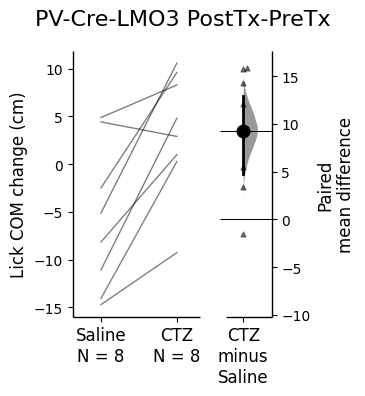

In [27]:
#read datas
import os
import pandas as pd
from tkinter import Tk, filedialog


# 定義參數並繪製圖形
idx = ("Saline", "CTZ")
x = "Condition"
y = "Lick COM change (cm)"
Paired = "baseline"
Mice_id = "Mice_id"
title = "PV-Cre-LMO3 PostTx-PreTx"

root = Tk()
root.attributes('-topmost', True)  # 將主視窗設置為最上層
root.withdraw()
file = filedialog.askopenfilenames(parent=root, title='選擇資料檔案', filetypes=[('CSV files', '*.csv')])

#讀取DF
long_data = pd.read_csv(file[0])

# 是否保存圖表
save_fig = True

if save_fig:
    root = Tk()
    root.attributes('-topmost', True)  # 將主視窗設置為最上層
    root.withdraw()

    plot_save_dir = filedialog.askdirectory(parent=root, title='選擇plot儲存位置')
    basename = os.path.basename(plot_save_dir)  # 如 '2000ng'
    dirname = os.path.basename(os.path.dirname(plot_save_dir))  # 如 'muscle injection'

    treatment = f"{dirname}_{basename}_schedule"

# 繪製圖表
permutation_test_plot(long_data, idx, x, y, Paired, Mice_id, title)